In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, MultivariateNormal, MixtureSameFamily, Categorical
import numpy as np
import matplotlib.pyplot as plt

from avs_sampler import AuxiliaryVariationalSampler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps") # for macos

/home/ilya/anaconda3/envs/Work/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class BananaDistribution:
    def __init__(self, sigma1=1.0, sigma2=1.0, b=0.1):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.b = b
        self.c = b * sigma1**2
    
    def log_prob(self, x):
        """x: [batch_size, 2]"""
        x1, x2 = x[:, 0], x[:, 1]
        term1 = -0.5 * (x1**2) / (self.sigma1**2)
        term2 = -0.5 * ((x2 - self.b * x1**2 + self.c)**2) / (self.sigma2**2)
        return term1 + term2
    
    def sample(self, n):
        """Generate ground truth samples"""
        z1 = torch.randn(n) * self.sigma1
        z2 = torch.randn(n) * self.sigma2
        x1 = z1
        x2 = z2 + self.b * z1**2 - self.c
        return torch.stack([x1, x2], dim=1)


class FunnelDistribution:
    def __init__(self, sigma_v=3.0):
        self.sigma_v = sigma_v
    
    def log_prob(self, x):
        """x: [batch_size, 2], x[:, 0] = v, x[:, 1] = x"""
        v, x_val = x[:, 0], x[:, 1]
        log_p_v = -0.5 * (v**2) / (self.sigma_v**2)
        log_p_x_given_v = -0.5 * (x_val**2) * torch.exp(-v) - 0.5 * v
        return log_p_v + log_p_x_given_v
    
    def sample(self, n):
        """Generate ground truth samples"""
        v = torch.randn(n) * self.sigma_v
        x = torch.randn(n) * torch.exp(v / 2)
        return torch.stack([v, x], dim=1)

In [4]:
def random_walk_metropolis(log_prob_fn, initial_x, num_samples, step_size=0.5, burn_in=500):
    samples = []
    x = initial_x.clone()
    accepts = 0
    total = 0
    
    for i in range(burn_in + num_samples):
        x_proposed = x + torch.randn_like(x) * step_size
        log_alpha = log_prob_fn(x_proposed.unsqueeze(0)) - log_prob_fn(x.unsqueeze(0))
        
        u = torch.rand(1)
        accept = torch.log(u) < log_alpha
        
        if accept:
            x = x_proposed
            accepts += 1
        
        total += 1
        
        if i >= burn_in:
            samples.append(x.clone())
    
    print(f"RWM acceptance rate: {accepts / total:.2%}")
    return torch.stack(samples).numpy()


def mala(log_prob_fn, initial_x, num_samples, step_size=0.1, burn_in=500):
    samples = []
    x = initial_x.clone().requires_grad_(True)
    accepts = 0
    total = 0
    
    for i in range(burn_in + num_samples):
        # Gradient at current point
        log_p = log_prob_fn(x.unsqueeze(0))
        grad = torch.autograd.grad(log_p, x)[0]
        
        # Proposal
        with torch.no_grad():
            noise = torch.randn_like(x)
            x_proposed = x + 0.5 * step_size**2 * grad + step_size * noise
        
        x_proposed.requires_grad_(True)
        
        # Gradient at proposed point
        log_p_proposed = log_prob_fn(x_proposed.unsqueeze(0))
        grad_proposed = torch.autograd.grad(log_p_proposed, x_proposed)[0]
        
        with torch.no_grad():
            # Log proposal densities
            diff_forward = x_proposed - x - 0.5 * step_size**2 * grad
            diff_backward = x - x_proposed - 0.5 * step_size**2 * grad_proposed
            
            log_q_forward = -0.5 * torch.sum(diff_forward**2) / step_size**2
            log_q_backward = -0.5 * torch.sum(diff_backward**2) / step_size**2
            
            # Acceptance
            log_alpha = (log_p_proposed - log_p + log_q_backward - log_q_forward).item()
            
            accept = torch.log(torch.rand(1)).item() < log_alpha
            if accept:
                x = x_proposed
                accepts += 1
            else:
                x = x.detach().requires_grad_(True)
            
            total += 1
        
        if i >= burn_in:
            samples.append(x.detach().clone())
    
    print(f"MALA acceptance rate: {accepts / total:.2%}")
    return torch.stack(samples).numpy()

In [5]:
def effective_sample_size(samples):
    """Calculate ESS via autocorrelation (Geyer's method)"""
    n = len(samples)
    if samples.ndim == 1:
        samples = samples.reshape(-1, 1)
    
    ess_per_dim = []
    for d in range(samples.shape[1]):
        x = samples[:, d]
        x = x - np.mean(x)
        
        # FFT
        f = np.fft.fft(x, n=2*n)
        acf = np.fft.ifft(f * np.conjugate(f))[:n].real
        acf = acf / (acf[0] + 1e-10)
        
        # Geyer's initial positive sequence
        cutoff = 1
        for k in range(1, n-1, 2):
            if (acf[k] + acf[k+1]) < 0:
                cutoff = k
                break
        else:
            cutoff = n - 1
        
        # Integrated autocorrelation time
        tau = 1 + 2 * np.sum(acf[1:cutoff])
        ess_per_dim.append(n / max(tau, 1))
    
    return np.min(ess_per_dim)

### BANANA DISTRIBUTION

In [6]:
torch.manual_seed(42)
np.random.seed(42)

NUM_SAMPLES = 3000

print("=" * 50)
print("BANANA DISTRIBUTION")
print("=" * 50)

banana = BananaDistribution(sigma1=2.0, sigma2=2.0, b=0.5)
initial_banana = torch.tensor([0.0, -2.0])

# Ground truth
gt_samples = banana.sample(5000).numpy()

# AVS
print("\nTraining AVS...")
avs = AuxiliaryVariationalSampler(
    target_logprob=banana.log_prob,
    target_dim=2,
    aux_dim=1,
    hidden_dim=64,
    perturb=0.3
)
losses = avs.train(max_iters=10000, print_freq=500)

print("\nSampling with AVS...")
avs_samples = avs.sample(NUM_SAMPLES, num_chains=1, burn_in= 500, initial_x=initial_banana)[:, 0, :]



BANANA DISTRIBUTION

Training AVS...
Iter 0: loss = -2.2042
Iter 500: loss = -2.9218
Iter 1000: loss = -2.9078
Iter 1500: loss = -2.8790
Iter 2000: loss = -3.1129
Iter 2500: loss = -2.8992
Iter 3000: loss = -2.5881
Iter 3500: loss = -2.8197
Iter 4000: loss = -2.9916
Iter 4500: loss = -2.9319
Iter 5000: loss = -2.9376
Iter 5500: loss = -2.9310
Iter 6000: loss = -2.8578
Iter 6500: loss = -2.9291
Iter 7000: loss = -2.8666
Iter 7500: loss = -2.8706
Iter 8000: loss = -2.9582
Iter 8500: loss = -2.8785
Iter 9000: loss = -2.9261
Iter 9500: loss = -2.7944

Sampling with AVS...
Acceptance rate: 65.10%


In [7]:
# RWM
print("\nSampling with RWM...")
rwm_samples = random_walk_metropolis(
    banana.log_prob,
    initial_banana,
    NUM_SAMPLES,
    step_size=0.8
)

# MALA
print("\nSampling with MALA...")
mala_samples = mala(
    banana.log_prob,
    initial_banana,
    NUM_SAMPLES,
    step_size=0.8
)

# ESS
print("\n--- ESS Results (Banana) ---")
print(f"AVS:  {effective_sample_size(avs_samples):.1f}")
print(f"RWM:  {effective_sample_size(rwm_samples):.1f}")
print(f"MALA: {effective_sample_size(mala_samples):.1f}")


Sampling with RWM...
RWM acceptance rate: 70.29%

Sampling with MALA...
MALA acceptance rate: 88.91%

--- ESS Results (Banana) ---
AVS:  132.2
RWM:  9.0
MALA: 19.3


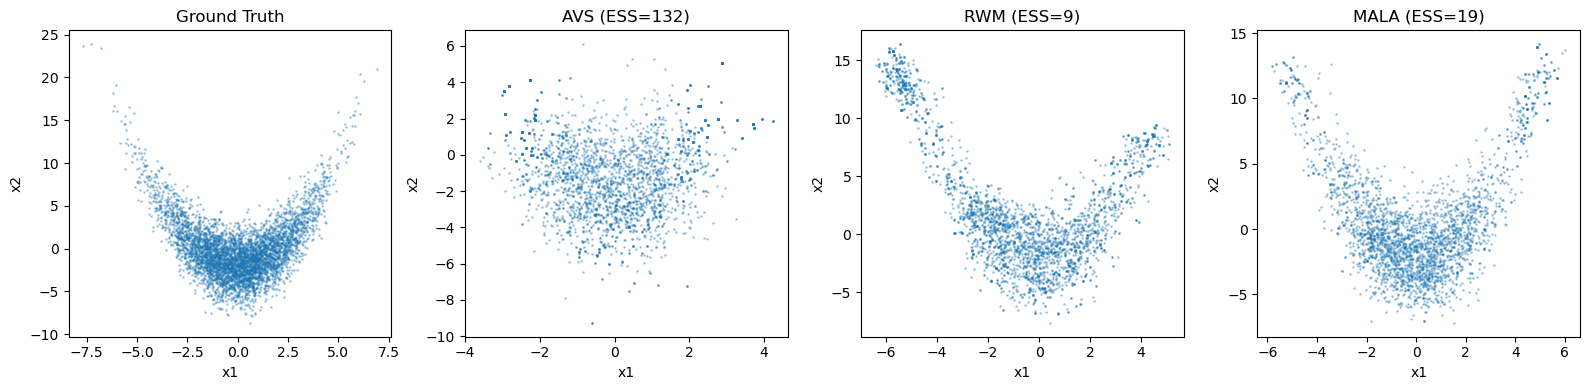

In [8]:
# Визуализация
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].scatter(gt_samples[:, 0], gt_samples[:, 1], alpha=0.3, s=1)
axes[0].set_title('Ground Truth')

axes[1].scatter(avs_samples[:, 0], avs_samples[:, 1], alpha=0.3, s=1)
axes[1].set_title(f'AVS (ESS={effective_sample_size(avs_samples):.0f})')

axes[2].scatter(rwm_samples[:, 0], rwm_samples[:, 1], alpha=0.3, s=1)
axes[2].set_title(f'RWM (ESS={effective_sample_size(rwm_samples):.0f})')

axes[3].scatter(mala_samples[:, 0], mala_samples[:, 1], alpha=0.3, s=1)
axes[3].set_title(f'MALA (ESS={effective_sample_size(mala_samples):.0f})')

for ax in axes:
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

plt.tight_layout()
plt.show()


### FUNNEL DISTRIBUTION

In [9]:
print("\n" + "=" * 50)
print("FUNNEL DISTRIBUTION")
print("=" * 50)

funnel = FunnelDistribution(sigma_v=2.0)

# Ground truth
gt_funnel = funnel.sample(5000).numpy()

# AVS
print("\nTraining AVS...")
avs_funnel = AuxiliaryVariationalSampler(
    target_logprob=funnel.log_prob,
    target_dim=2,
    aux_dim=1,
    hidden_dim=64,
    perturb=0.3
)
losses_funnel = avs_funnel.train(max_iters=3000, print_freq=500)

print("\nSampling with AVS...")
avs_funnel_samples = avs_funnel.sample(NUM_SAMPLES, num_chains=1)[:, 0, :]

print("\nSampling with RWM...")
rwm_funnel = random_walk_metropolis(
    funnel.log_prob,
    torch.zeros(2),
    NUM_SAMPLES,
    step_size=0.5
)

mala_funnel = mala(
    funnel.log_prob,
    torch.zeros(2),
    NUM_SAMPLES,
    step_size=0.6
)


FUNNEL DISTRIBUTION

Training AVS...
Iter 0: loss = -1.8335
Iter 500: loss = -2.4160
Iter 1000: loss = -2.4484
Iter 1500: loss = -2.3876
Iter 2000: loss = -2.4317
Iter 2500: loss = -2.5168

Sampling with AVS...
Acceptance rate: 82.47%

Sampling with RWM...
RWM acceptance rate: 68.23%
MALA acceptance rate: 79.17%


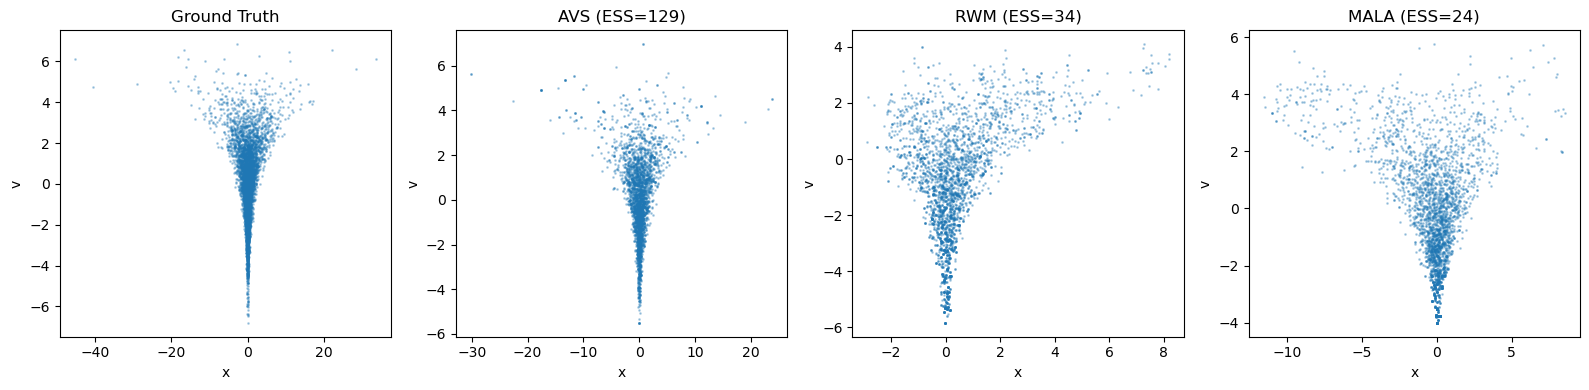

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].scatter(gt_funnel[:, 1], gt_funnel[:, 0], alpha=0.3, s=1)
axes[0].set_title('Ground Truth')

axes[1].scatter(avs_funnel_samples[:, 1], avs_funnel_samples[:, 0], alpha=0.3, s=1)
axes[1].set_title(f'AVS (ESS={effective_sample_size(avs_funnel_samples):.0f})')

axes[2].scatter(rwm_funnel[:, 1], rwm_funnel[:, 0], alpha=0.3, s=1)
axes[2].set_title(f'RWM (ESS={effective_sample_size(rwm_funnel):.0f})')

axes[3].scatter(mala_funnel[:, 1], mala_funnel[:, 0], alpha=0.3, s=1)
axes[3].set_title(f'MALA (ESS={effective_sample_size(mala_funnel):.0f})')

for ax in axes:
    ax.set_xlabel('x')
    ax.set_ylabel('v')

plt.tight_layout()
plt.show()

In [11]:
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [12]:
class ColoredMNIST(Dataset):
    def __init__(self, root='./data', train=True, color_mode='random'):
        self.mnist = datasets.MNIST(root=root, train=train, download=True)
        self.color_mode = color_mode
        
        self.class_colors = torch.tensor([
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, 1.0],
            [1.0, 1.0, 0.0],
            [1.0, 0.0, 1.0],
            [0.0, 1.0, 1.0],
            [1.0, 0.5, 0.0],
            [0.5, 0.0, 1.0],
            [0.5, 1.0, 0.5],
            [1.0, 0.5, 0.5],
        ])
    
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        img = transforms.ToTensor()(img)
        
        if self.color_mode == 'random':
            color = torch.rand(3)
            color = color / color.max()
        elif self.color_mode == 'class_dependent':
            color = self.class_colors[label]
            color = color + torch.randn(3) * 0.1
            color = torch.clamp(color, 0, 1)
        else:
            color = torch.ones(3)
        
        colored_img = img * color.view(3, 1, 1)
        
        return colored_img, label

In [13]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        
        self.fc = nn.Linear(128 * 3 * 3, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
    
    def forward(self, x):
        # x: [batch, 3, 28, 28]
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = h.view(h.size(0), -1)  # flatten
        h = F.relu(self.fc(h))
        
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        
        self.fc = nn.Linear(latent_dim, 128 * 3 * 3)
        
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 3→6
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0)   # 6→14
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)    # 14→28
    
    def forward(self, z):
        h = F.relu(self.fc(z))
        h = h.view(h.size(0), 128, 3, 3)
        h = F.relu(self.deconv1(h))
        h = F.relu(self.deconv2(h))
        x_recon = torch.sigmoid(self.deconv3(h))
        
        x_recon = F.interpolate(x_recon, size=(28, 28), mode='bilinear', align_corners=False)
        
        return x_recon


class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z
    
    def loss_function(self, x, x_recon, mu, logvar):
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_loss, recon_loss, kl_loss
    
    def log_prob_z_given_x(self, z, x):
        x_recon = self.decode(z)
        
        if x.dim() == 3:
            x = x.unsqueeze(0)  # [1, 3, 28, 28]
        x_expanded = x.expand(z.size(0), -1, -1, -1)  # [batch, 3, 28, 28]
        
        reconstruction_error = ((x_recon - x_expanded) ** 2).sum(dim=[1, 2, 3])
        log_p_x_given_z = -0.5 * reconstruction_error
        
        # log p(z) = log N(z | 0, I)
        log_p_z = -0.5 * (z ** 2).sum(dim=-1)
        
        return log_p_x_given_z + log_p_z

In [14]:
def train_vae(vae, train_loader, epochs=20, lr=1e-3):
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    vae.train()
    
    losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            optimizer.zero_grad()
            
            x_recon, mu, logvar, z = vae(data)
            loss, recon, kl = vae.loss_function(data, x_recon, mu, logvar)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()
        
        avg_loss = total_loss / len(train_loader.dataset)
        avg_recon = total_recon / len(train_loader.dataset)
        avg_kl = total_kl / len(train_loader.dataset)
        
        losses.append(avg_loss)
        
        print(f"Epoch {epoch+1}/{epochs}: Loss={avg_loss:.4f} "
              f"(Recon={avg_recon:.4f}, KL={avg_kl:.4f})")
    
    return losses


In [15]:
def _init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [16]:
def rwm_for_vae(vae, x, num_samples=1000, step_size=0.3, burn_in=200):
    x_fixed = x.unsqueeze(0).to(device) if x.dim() == 3 else x.to(device)
    
    samples = []
    z = torch.zeros(1, vae.latent_dim, device=device)
    accepts = 0
    
    with torch.no_grad():
        for i in range(burn_in + num_samples):
            z_proposed = z + torch.randn_like(z) * step_size
            
            log_alpha = (
                vae.log_prob_z_given_x(z_proposed, x_fixed) -
                vae.log_prob_z_given_x(z, x_fixed)
            )
            
            if torch.log(torch.rand(1, device=device)) < log_alpha:
                z = z_proposed
                if i >= burn_in:
                    accepts += 1
            
            if i >= burn_in:
                samples.append(z.clone())
    
    print(f"RWM acceptance rate: {accepts / num_samples:.2%}")
    return torch.cat(samples, dim=0)


def mala_for_vae(vae, x, num_samples=1000, step_size=0.1, burn_in=200):
    x_fixed = x.unsqueeze(0).to(device) if x.dim() == 3 else x.to(device)
    
    samples = []
    z = torch.zeros(1, vae.latent_dim, device=device, requires_grad=True)
    accepts = 0
    
    for i in range(burn_in + num_samples):
        # Gradient
        log_p = vae.log_prob_z_given_x(z, x_fixed)
        log_p.backward()
        grad = z.grad.clone()
        z.grad.zero_()
        
        # Proposal
        noise = torch.randn_like(z)
        z_proposed = z.detach() + 0.5 * step_size**2 * grad + step_size * noise
        z_proposed.requires_grad_(True)
        
        # Gradient at proposal
        log_p_proposed = vae.log_prob_z_given_x(z_proposed, x_fixed)
        log_p_proposed.backward()
        grad_proposed = z_proposed.grad.clone()
        z_proposed.grad.zero_()
        
        # Proposal densities
        log_q_forward = -0.5 * ((z_proposed.detach() - z.detach() - 0.5 * step_size**2 * grad)**2).sum() / step_size**2
        log_q_backward = -0.5 * ((z.detach() - z_proposed.detach() - 0.5 * step_size**2 * grad_proposed)**2).sum() / step_size**2
        
        log_alpha = log_p_proposed.detach() - log_p.detach() + log_q_backward - log_q_forward
        
        if torch.log(torch.rand(1)) < log_alpha.cpu():
            z = z_proposed.detach().requires_grad_(True)
            if i >= burn_in:
                accepts += 1
        else:
            z = z.detach().requires_grad_(True)
        
        if i >= burn_in:
            samples.append(z.detach().clone())
    
    print(f"MALA acceptance rate: {accepts / num_samples:.2%}")
    return torch.cat(samples, dim=0)


In [17]:
def effective_sample_size(samples):
    if isinstance(samples, torch.Tensor):
        samples = samples.cpu().numpy()
    
    n = len(samples)
    ess_per_dim = []
    
    for d in range(samples.shape[1]):
        x = samples[:, d]
        x = x - np.mean(x)
        
        f = np.fft.fft(x, n=2*n)
        acf = np.fft.ifft(f * np.conjugate(f))[:n].real
        acf = acf / (acf[0] + 1e-10)
        
        negative_idx = np.where(acf < 0.05)[0]
        cutoff = negative_idx[0] if len(negative_idx) > 0 else n
        
        tau = 1 + 2 * np.sum(acf[1:cutoff])
        ess_per_dim.append(n / max(tau, 1))
    
    return np.min(ess_per_dim)


def reconstruction_quality(vae, z_samples, x_true):
    with torch.no_grad():
        x_recons = vae.decode(z_samples)
        x_true_expanded = x_true.unsqueeze(0).expand(z_samples.size(0), -1, -1, -1)
        mse = F.mse_loss(x_recons, x_true_expanded, reduction='none').mean(dim=[1,2,3])
    return mse.mean().item(), mse.std().item()


STEP 1: Loading Colored MNIST
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.62MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 227kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.77MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.16MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



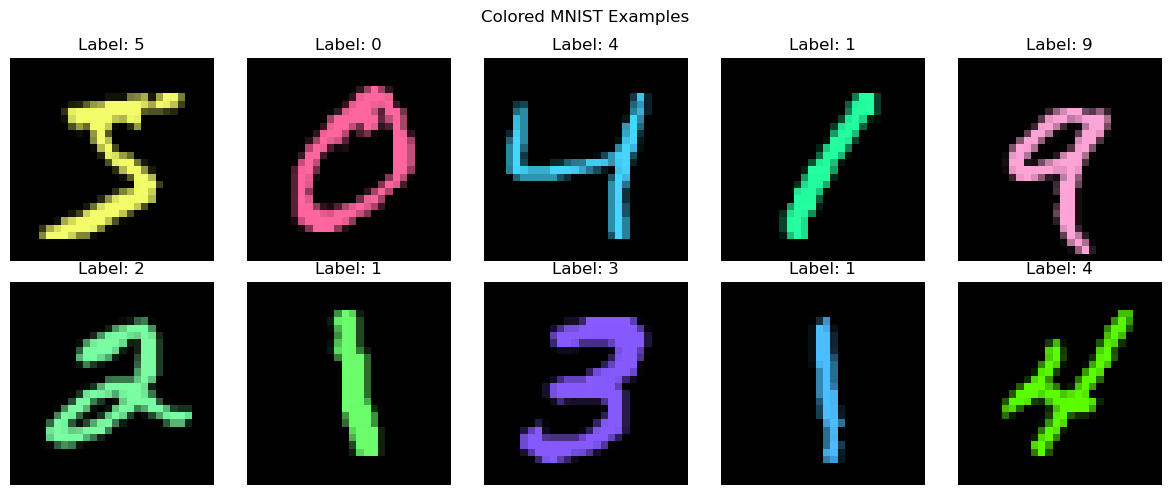

In [18]:
torch.manual_seed(42)

print("=" * 60)
print("STEP 1: Loading Colored MNIST")
print("=" * 60)

train_dataset = ColoredMNIST(train=True, color_mode='random')
test_dataset = ColoredMNIST(train=False, color_mode='random')

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.suptitle("Colored MNIST Examples")
plt.tight_layout()
plt.show()


STEP 2: Training VAE
Epoch 1/15: Loss=488.2106 (Recon=474.3473, KL=13.8633)
Epoch 2/15: Loss=346.2754 (Recon=322.6621, KL=23.6133)
Epoch 3/15: Loss=328.8278 (Recon=303.4308, KL=25.3970)
Epoch 4/15: Loss=321.3765 (Recon=294.9229, KL=26.4536)
Epoch 5/15: Loss=303.4841 (Recon=275.0757, KL=28.4085)
Epoch 6/15: Loss=293.0950 (Recon=263.6915, KL=29.4035)
Epoch 7/15: Loss=275.1735 (Recon=244.3416, KL=30.8319)
Epoch 8/15: Loss=270.9176 (Recon=239.9408, KL=30.9768)
Epoch 9/15: Loss=268.8475 (Recon=237.7834, KL=31.0640)
Epoch 10/15: Loss=267.2011 (Recon=236.0839, KL=31.1172)
Epoch 11/15: Loss=265.3691 (Recon=234.1699, KL=31.1992)
Epoch 12/15: Loss=264.5708 (Recon=233.2910, KL=31.2798)
Epoch 13/15: Loss=263.5122 (Recon=232.1769, KL=31.3354)
Epoch 14/15: Loss=262.7810 (Recon=231.4054, KL=31.3756)
Epoch 15/15: Loss=262.3442 (Recon=230.9633, KL=31.3809)


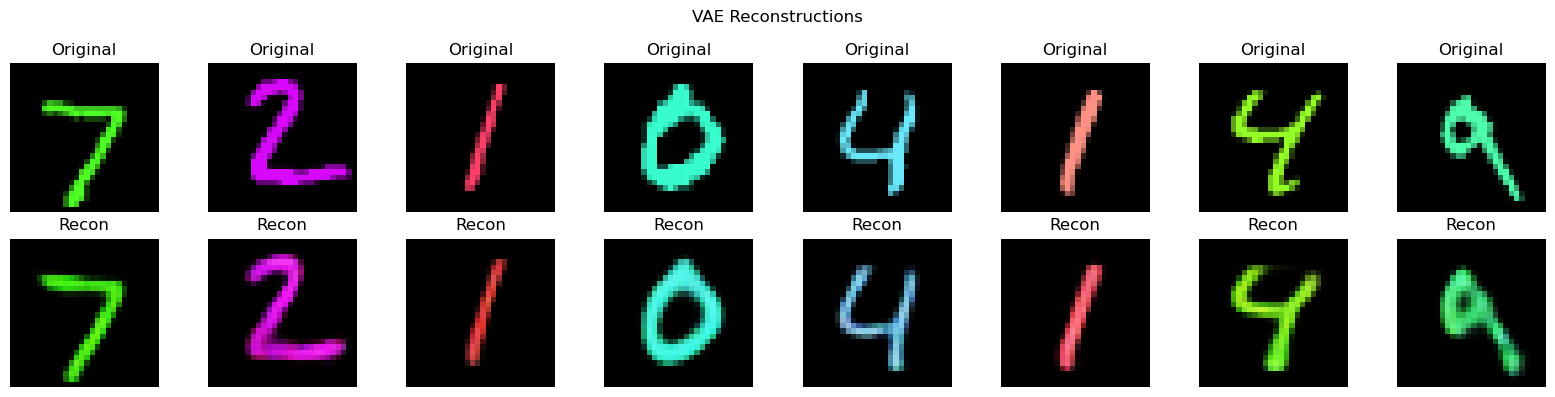

In [19]:
print("\n" + "=" * 60)
print("STEP 2: Training VAE")
print("=" * 60)

LATENT_DIM = 16
vae = VAE(latent_dim=LATENT_DIM).to(device)

vae_losses = train_vae(vae, train_loader, epochs=15, lr=1e-3)

torch.save(vae.state_dict(), 'vae_colored_mnist.pt')

vae.eval()
with torch.no_grad():
    test_imgs, _ = next(iter(test_loader))
    test_imgs = test_imgs[:8].to(device)
    recons, _, _, _ = vae(test_imgs)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(test_imgs[i].cpu().permute(1, 2, 0).numpy())
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')
    axes[1, i].imshow(recons[i].cpu().permute(1, 2, 0).numpy())
    axes[1, i].axis('off')
    axes[1, i].set_title('Recon')
plt.suptitle("VAE Reconstructions")
plt.tight_layout()
plt.show()


In [20]:
def _init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class AVS_Encoder(nn.Module):
    """p_θ(a|z): encoder для AVS"""
    
    def __init__(self, latent_dim, aux_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
        )
        self.mu = nn.Linear(hidden_dim, aux_dim)
        self.logvar = nn.Linear(hidden_dim, aux_dim)
    
    def forward(self, z):
        h = self.net(z)
        logvar = torch.clamp(self.logvar(h), -10, 4)
        return Normal(self.mu(h), torch.exp(0.5 * logvar))


class AVS_Decoder(nn.Module):
    """q_φ(z|a): decoder для AVS"""
    
    def __init__(self, latent_dim, aux_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(aux_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
        )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, a):
        h = self.net(a)
        logvar = torch.clamp(self.logvar(h), -10, 4)
        return Normal(self.mu(h), torch.exp(0.5 * logvar))


class AVS_for_VAE:
    """Auxiliary Variable Sampler for VAE"""
    
    def __init__(self, vae, aux_dim=4, hidden_dim=64, perturb=0.25):
        self.vae = vae
        self.vae.eval()
        
        self.latent_dim = vae.latent_dim
        self.aux_dim = aux_dim
        self.perturb = perturb
        
        self.avs_encoder = AVS_Encoder(self.latent_dim, aux_dim, hidden_dim).to(device)
        self.avs_decoder = AVS_Decoder(self.latent_dim, aux_dim, hidden_dim).to(device)

        self.avs_encoder.apply(_init_weights)
        self.avs_decoder.apply(_init_weights)
        
        # For regularization
        self.encoder_mu = None
        self.encoder_logvar = None
    
    def get_prior_a(self, batch_size=1):
        return Normal(
            torch.zeros(batch_size, self.aux_dim, device=device),
            torch.ones(batch_size, self.aux_dim, device=device)
        )
    
    def initialize_from_encoder(self, x):
        with torch.no_grad():
            x_input = x.unsqueeze(0) if x.dim() == 3 else x
            mu, logvar = self.vae.encode(x_input)
            self.encoder_mu = mu[0]
            self.encoder_logvar = logvar[0]
            
            self.avs_decoder.mu.bias.data.copy_(self.encoder_mu)
    
    def train(self, x, max_iters=1500, lr=3e-4, print_freq=300, batch_size=16, 
              reg_weight=0.5, min_reg_weight=0.1):
        optimizer = optim.Adam(
            list(self.avs_encoder.parameters()) + 
            list(self.avs_decoder.parameters()),
            lr=lr
        )
        
        self.initialize_from_encoder(x)
        
        x_fixed = x.unsqueeze(0).to(device) if x.dim() == 3 else x.to(device)
        x_batch = x_fixed.repeat(batch_size, *([1] * (x_fixed.dim() - 1)))
        
        losses = []
        components = {
            'total': [], 'kl': [], 'reg': [],
            'log_p_a': [], 'log_q_z': [], 'log_p_a_z': [], 'log_target': []
        }
        
        print(f"\n🎯 Training AVS:")
        print(f"   Batch size: {batch_size}, LR: {lr}")
        print(f"   Reg: {reg_weight} → {min_reg_weight}")
        
        for t in range(max_iters):
            optimizer.zero_grad()
            
            # Sample a ~ p(a) = N(0, I)
            prior_a = self.get_prior_a(batch_size)
            a = prior_a.sample()
            
            # Sample z ~ q(z|a)
            q_z_given_a = self.avs_decoder(a)
            z = q_z_given_a.rsample()
            
            # p(a|z)
            p_a_given_z = self.avs_encoder(z)
            
            # Target log prob
            with torch.no_grad():
                target_log_prob = self.vae.log_prob_z_given_x(z, x_batch)
                if target_log_prob.dim() > 1:
                    target_log_prob = target_log_prob.sum(dim=list(range(1, target_log_prob.dim())))
            
            # Log probs
            log_p_a = prior_a.log_prob(a).sum(dim=-1)
            log_q_z = q_z_given_a.log_prob(z).sum(dim=-1)
            log_p_a_z = p_a_given_z.log_prob(a).sum(dim=-1)
            
            # KL loss
            kl_loss = (log_p_a + log_q_z - log_p_a_z - target_log_prob).mean()
            
            # Regularization
            warmup_progress = min(1.0, t / (max_iters * 0.66))
            current_reg_weight = reg_weight - (reg_weight - min_reg_weight) * warmup_progress
            
            # KL(q(z|a) || encoder_posterior) - hold decoder close к encoder
            q_mu = q_z_given_a.mean
            q_logvar = 2 * torch.log(q_z_given_a.stddev)
            
            kl_reg = -0.5 * torch.sum(
                1 + q_logvar - self.encoder_logvar - 
                ((q_mu - self.encoder_mu).pow(2) + q_logvar.exp()) / self.encoder_logvar.exp(),
                dim=-1
            ).mean()
            
            reg_loss = kl_reg * current_reg_weight
            
            # Total loss
            loss = kl_loss + reg_loss
            
            # Check stability
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠️ NaN/Inf at iteration {t}, stopping")
                break
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                list(self.avs_encoder.parameters()) +
                list(self.avs_decoder.parameters()),
                max_norm=1.0
            )
            
            optimizer.step()
            
            # Logging
            losses.append(loss.item())
            components['total'].append(loss.item())
            components['kl'].append(kl_loss.item())
            components['reg'].append(reg_loss.item())
            components['log_p_a'].append(log_p_a.mean().item())
            components['log_q_z'].append(log_q_z.mean().item())
            components['log_p_a_z'].append(log_p_a_z.mean().item())
            components['log_target'].append(target_log_prob.mean().item())
            
            if t % print_freq == 0:
                print(f"\nIter {t}: loss = {loss.item():.3f}")
                print(f"  KL: {kl_loss.item():.3f}, Reg: {reg_loss.item():.3f} (w={current_reg_weight:.3f})")
                print(f"  log_target={target_log_prob.mean():.2f}")
        
        final_target = components['log_target'][-1]
        initial_target = components['log_target'][0]
        print(f"\n✅ Training finished!")
        print(f"   Initial log_target: {initial_target:.2f}")
        print(f"   Final log_target: {final_target:.2f}")
        
        return losses, components
    
    def sample(self, x, num_samples=500, burn_in=200):
        self.avs_encoder.eval()
        self.avs_decoder.eval()
        
        x_fixed = x.unsqueeze(0).to(device) if x.dim() == 3 else x.to(device)
        
        samples = []
        
        with torch.no_grad():
            mu, logvar = self.vae.encode(x_fixed)
            z = self.vae.reparameterize(mu, logvar)
            
            accepts = 0
            
            for i in range(burn_in + num_samples):
                # 1. Encode: a ~ p(a|z)
                p_a_given_z = self.avs_encoder(z)
                a = p_a_given_z.sample()
                
                # 2. Random walk в auxiliary space
                a_prime = a + torch.randn_like(a) * self.perturb
                
                # 3. Decode: z' ~ q(z|a')
                q_z_given_a_prime = self.avs_decoder(a_prime)
                z_proposed = q_z_given_a_prime.sample()
                
                # 4. Compute acceptance ratio
                q_z_given_a = self.avs_decoder(a)
                p_a_prime_given_z_proposed = self.avs_encoder(z_proposed)
                
                log_alpha = (
                    q_z_given_a.log_prob(z).sum(dim=-1) +
                    p_a_prime_given_z_proposed.log_prob(a_prime).sum(dim=-1) +
                    self.vae.log_prob_z_given_x(z_proposed, x_fixed).squeeze() -
                    q_z_given_a_prime.log_prob(z_proposed).sum(dim=-1) -
                    p_a_given_z.log_prob(a).sum(dim=-1) -
                    self.vae.log_prob_z_given_x(z, x_fixed).squeeze()
                )
                
                log_alpha = torch.clamp(log_alpha, -20, 20)
                
                # 5. Accept/reject
                if torch.log(torch.rand(1, device=device)) < log_alpha:
                    z = z_proposed
                    if i >= burn_in:
                        accepts += 1
                
                if i >= burn_in:
                    samples.append(z.clone())
            
            acc_rate = accepts / num_samples
            print(f"\n✅ AVS sampling completed")
            print(f"   Acceptance rate: {acc_rate:.1%}")
        
        return torch.cat(samples, dim=0)

In [25]:
print("\n" + "=" * 60)
print("STEP 3: MCMC Sampling in Latent Space")
print("=" * 60)

test_img, test_label = test_dataset[0]
test_img = test_img.to(device)

print(f"\nTest image label: {test_label}")

NUM_SAMPLES = 500

print("\n--- Encoder (VAE baseline) ---")
with torch.no_grad():
    mu, logvar = vae.encode(test_img.unsqueeze(0))
    encoder_samples = vae.reparameterize(
        mu.expand(NUM_SAMPLES, -1),
        logvar.expand(NUM_SAMPLES, -1)
    )
print(f"Encoder samples shape: {encoder_samples.shape}")

# --- RWM ---
print("\n--- Random Walk Metropolis ---")
rwm_samples = rwm_for_vae(vae, test_img, num_samples=NUM_SAMPLES, step_size=0.25)

# --- MALA ---
print("\n--- MALA ---")
mala_samples = mala_for_vae(vae, test_img, num_samples=NUM_SAMPLES, step_size=0.3)

# --- AVS ---
print("\n--- AVS ---")
avs = AVS_for_VAE(vae, aux_dim=8, perturb=0.2)
avs_losses = avs.train(test_img, max_iters=1500, print_freq=300, lr=1e-4, reg_weight=1, min_reg_weight=0.2)
avs_samples = avs.sample(test_img, num_samples=NUM_SAMPLES)



STEP 3: MCMC Sampling in Latent Space

Test image label: 7

--- Encoder (VAE baseline) ---
Encoder samples shape: torch.Size([500, 16])

--- Random Walk Metropolis ---
RWM acceptance rate: 7.60%

--- MALA ---
MALA acceptance rate: 28.60%

--- AVS ---

🎯 Training AVS:
   Batch size: 16, LR: 0.0001
   Reg: 1 → 0.2

Iter 0: loss = 597.115
  KL: 43.602, Reg: 553.513 (w=1.000)
  log_target=-65.22

Iter 300: loss = 333.724
  KL: 41.228, Reg: 292.496 (w=0.758)
  log_target=-63.39

Iter 600: loss = 145.244
  KL: 26.599, Reg: 118.645 (w=0.515)
  log_target=-45.56

Iter 900: loss = 34.451
  KL: 15.261, Reg: 19.190 (w=0.273)
  log_target=-26.80

Iter 1200: loss = 16.408
  KL: 11.250, Reg: 5.158 (w=0.200)
  log_target=-18.22

✅ Training finished!
   Initial log_target: -65.22
   Final log_target: -18.73

✅ AVS sampling completed
   Acceptance rate: 12.8%


In [26]:
print("\n" + "=" * 60)
print("STEP 4: Results Comparison")
print("=" * 60)

# ESS
print("\n--- Effective Sample Size ---")
print(f"Encoder (VAE):  {effective_sample_size(encoder_samples):.1f}")
print(f"RWM:            {effective_sample_size(rwm_samples):.1f}")
print(f"MALA:           {effective_sample_size(mala_samples):.1f}")
print(f"AVS:            {effective_sample_size(avs_samples):.1f}")

# Reconstruction quality
print("\n--- Reconstruction MSE (mean ± std) ---")
enc_mse = reconstruction_quality(vae, encoder_samples, test_img)
rwm_mse = reconstruction_quality(vae, rwm_samples, test_img)
mala_mse = reconstruction_quality(vae, mala_samples, test_img)
avs_mse = reconstruction_quality(vae, avs_samples, test_img)

print(f"Encoder (VAE):  {enc_mse[0]:.6f} ± {enc_mse[1]:.6f}")
print(f"RWM:            {rwm_mse[0]:.6f} ± {rwm_mse[1]:.6f}")
print(f"MALA:           {mala_mse[0]:.6f} ± {mala_mse[1]:.6f}")
print(f"AVS:            {avs_mse[0]:.6f} ± {avs_mse[1]:.6f}")



STEP 4: Results Comparison

--- Effective Sample Size ---
Encoder (VAE):  447.4
RWM:            6.5
MALA:           5.4
AVS:            8.8

--- Reconstruction MSE (mean ± std) ---
Encoder (VAE):  0.003612 ± 0.000600
RWM:            0.005875 ± 0.001291
MALA:           0.007709 ± 0.002114
AVS:            0.005610 ± 0.002092



STEP 5: Visualization


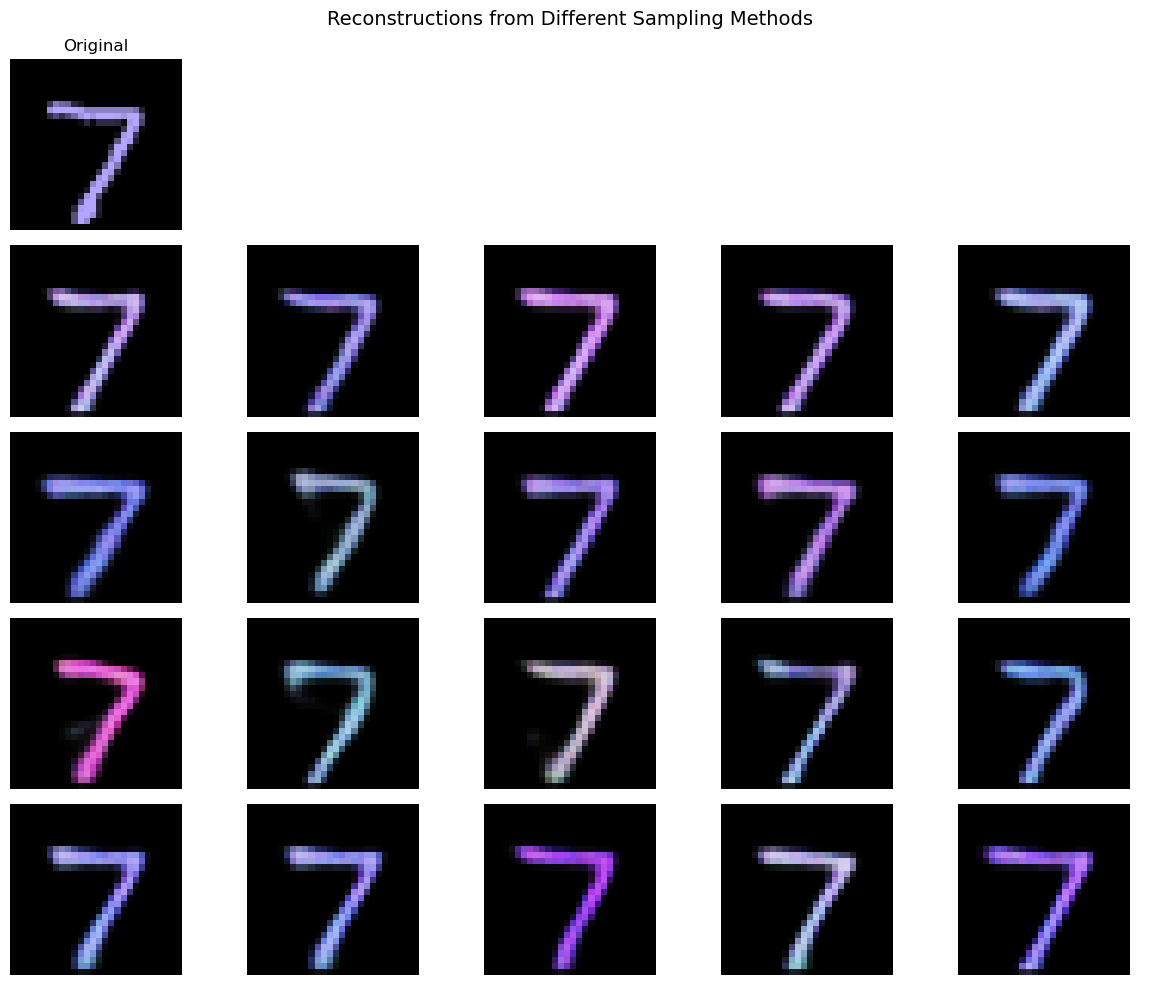

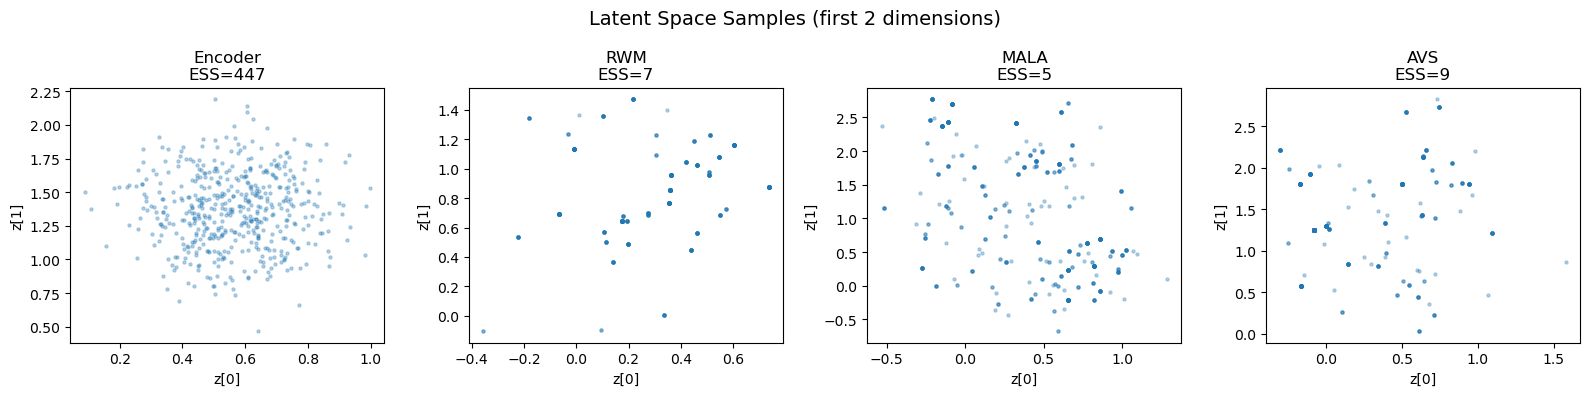

In [27]:
print("\n" + "=" * 60)
print("STEP 5: Visualization")
print("=" * 60)
fig, axes = plt.subplots(5, 5, figsize=(12, 10))

axes[0, 0].imshow(test_img.cpu().permute(1, 2, 0).numpy())
axes[0, 0].set_title("Original")
axes[0, 0].axis('off')
for j in range(1, 5):
    axes[0, j].axis('off')

methods = [
    ("Encoder", encoder_samples),
    ("RWM", rwm_samples),
    ("MALA", mala_samples),
    ("AVS", avs_samples)
]

with torch.no_grad():
    for row, (name, samples) in enumerate(methods, 1):
        axes[row, 0].set_ylabel(name, fontsize=12)
        for col in range(5):
            idx = col * (NUM_SAMPLES // 5)
            z = samples[idx:idx+1]
            recon = vae.decode(z)
            axes[row, col].imshow(recon[0].cpu().permute(1, 2, 0).numpy())
            axes[row, col].axis('off')

plt.suptitle("Reconstructions from Different Sampling Methods", fontsize=14)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, (name, samples) in zip(axes, methods):
    s = samples.cpu().numpy()
    ax.scatter(s[:, 0], s[:, 1], alpha=0.3, s=5)
    ax.set_title(f"{name}\nESS={effective_sample_size(samples):.0f}")
    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")

plt.suptitle("Latent Space Samples (first 2 dimensions)", fontsize=14)
plt.tight_layout()
plt.savefig('latent_space_2d.png', dpi=150)
plt.show()